chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://imumaster-1257689502.cos.ap-shanghai.myqcloud.com/2022/12/Inertial_Measurement_Unit_Error_Modeling_Tutorial_Inertial_Navigation_System_State_Estimation_with_Real-Time_Sensor_Calibration.pdf


<Axes: xlabel='Averaging time $\\tau$, s', ylabel='Allan deviation, unit'>

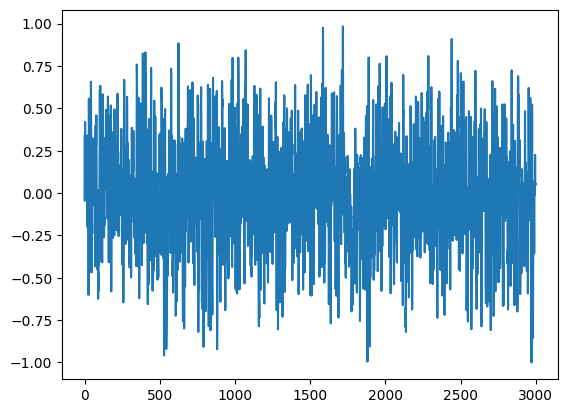

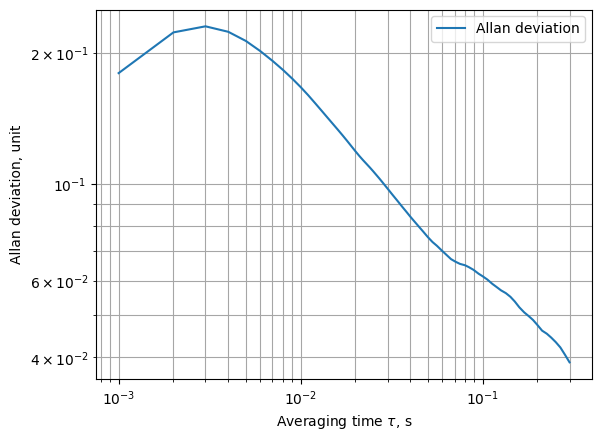

In [1]:
import numpy as np

def generate_pink_noise(duration, sample_rate):
    # Calculate the number of samples
    num_samples = int(duration * sample_rate)

    # Generate white noise
    white_noise = np.random.normal(0, 1, num_samples)

    # Create a filter to make the white noise pink
    b = [0.02109238, -0.07113478, 0.68873558, 0.31030734]
    a = [1.0, -0.55789837, 0.03367877, 0.06514808]

    # Apply the filter to the white noise
    pink_noise = np.zeros(num_samples)
    pink_noise[0] = white_noise[0]

    for i in range(1, num_samples):
        pink_noise[i] = b[0] * white_noise[i] + \
                        b[1] * white_noise[i - 1] + \
                        b[2] * white_noise[i - 2] + \
                        b[3] * white_noise[i - 3] - \
                        a[1] * pink_noise[i - 1] - \
                        a[2] * pink_noise[i - 2] - \
                        a[3] * pink_noise[i - 3]

    # Normalize the pink noise to be between -1 and 1
    pink_noise /= np.max(np.abs(pink_noise))

    return pink_noise


import matplotlib.pyplot as plt

sig = generate_pink_noise(
    duration= 3,
    sample_rate= 1000,
)

plt.plot(sig)


from firefly.math.allan import plot_allan_deviation, allan_variance

(tau, adev) = allan_variance(sig, 1/1000)

plot_allan_deviation(tau, np.sqrt(adev))






In [2]:
"""Noise generators for long streams of 1/f^alpha noise.

The time domain methods used here follow Stephane Plaszczynski, Fluct.
Noise Lett. 7: R-R13, 2007. DOI: 10.1142/S0219477507003635, see also
https://arxiv.org/abs/astro-ph/0510081. The code sticks to the notation
in this article (which is different to the SciPy docs).

Examples and documentation are available on GitHub:
https://github.com/janwaldmann/pyplnoise
"""

from typing import List, Optional, Tuple

import numpy as np
from scipy import signal


class WhiteNoise:
    """White noise generator (constant power spectrum)."""

    @property
    def fs(self) -> float:
        """Get the sampling frequency."""
        return self._fs

    @property
    def rms(self) -> float:
        """Get the noise signal RMS value."""
        return self._rms

    def __init__(self,
                 f_sample: float,
                 psd: float = 1.,
                 seed: Optional[int] = None) -> None:
        """Create a WhiteNoise instance.

        Args:
            f_sample: sampling frequency in Hz.
            psd: constant value of the two-sided power
                spectral density. The RMS value of the generated noise
                is sqrt(f_sample x psd).
            seed: seed for the random number generator. If none is provided,
                entropy from the system will be used.
        """
        self._fs = f_sample
        self._rms = np.sqrt(f_sample * psd)
        self._rng = np.random.default_rng(seed)

    def get_sample(self) -> float:
        """Retrieve a single sample."""
        return self._rng.normal(loc=0., scale=self.rms)

    def get_series(self, npts: int) -> np.ndarray:
        """Retrieve an array of npts samples."""
        if npts > np.iinfo(int).max:
            raise ValueError("""Argument 'npts' must be an integer <= {}.
If you want to obtain more samples, run get_series() several times and
concatenate the results.""".format(np.iinfo(int).max))
        return self._rng.normal(loc=0., scale=self.rms, size=npts)


class RedNoise:
    """Red (Brownian) noise generator (1/f^2 power spectrum).

    The two-sided power spectral density (PSD) is scaled such that
    PSD(f = 1 Hz) = 1. Below f_min, the noise is white.
    """

    @property
    def fs(self) -> float:
        """Get the sampling rate."""
        return self._fs

    @property
    def fmin(self) -> float:
        """Get the lower cutoff frequency."""
        return self._fmin

    def __init__(self,
                 f_sample: float,
                 f_min: float,
                 init_filter: bool = True,
                 seed: Optional[int] = None) -> None:
        """Create a RedNoise instance.

        Args:
            f_sample: sampling frequency in Hz.
            f_min: frequency cutoff in Hz. Below f_min, the noise
                will be white.
            init_filter: settle filter during object initialization. This
                might take some time depending on the magnitude of the
                ratio f_sample/f_min. Default and highly recommended: True.
            seed: seed for the random number generator. If none is
                provided, entropy from the system will be used.

        """
        self._fs = f_sample
        self._fmin = f_min
        self._whitenoise = WhiteNoise(self.fs, psd=1., seed=seed)
        self._scaling = 1. / (self.fs * self.fmin)
        self._a = np.array([2. * np.pi * self.fmin])
        self._b = np.array(
            [1., -1. * np.exp(-2. * np.pi * self.fmin / self.fs)])
        self._zi = signal.lfilter_zi(self._a,
                                     self._b) * self._whitenoise.get_sample()
        if init_filter:
            npts_req = np.ceil(2. * self.fs / self.fmin)
            # safeguard for machines with small memory
            npts_per_run_max = 150000000
            if npts_req > npts_per_run_max:
                for i in range(
                        np.ceil(npts_req / npts_per_run_max).astype(int)):
                    _ = self.get_series(npts_per_run_max)
            else:
                _ = self.get_series(int(npts_req))

    def get_sample(self) -> np.float64:
        """Retrieve a single sample."""
        sample, self._zi = signal.lfilter(self._a,
                                          self._b,
                                          np.array(
                                              [self._whitenoise.get_sample()]),
                                          zi=self._zi)
        return sample[0] * self._scaling

    def get_series(self, npts: int) -> np.ndarray:
        """Retrieve an array of npts samples."""
        if npts > np.iinfo(int).max:
            raise ValueError("""Argument 'npts' must be an integer <= {}.
If you want to obtain more samples, run get_series() several times and
concatenate the results.""".format(np.iinfo(int).max))
        samples, self._zi = signal.lfilter(self._a,
                                           self._b,
                                           self._whitenoise.get_series(npts),
                                           zi=self._zi)
        return samples * self._scaling


class AlphaNoise:
    """Colored noise noise generator (arbitrary 1/f^alpha power spectrum).

    The two-sided power spectral density (PSD) is scaled such that
    PSD(f = 1 Hz) = 1. The noise generator has user-specified lower and
    upper cutoff frequencies. Below and above these frequencies, the
    generated noise is white.
    """

    @property
    def fs(self) -> float:
        """Get the sampling rate."""
        return self._fs

    @property
    def fmin(self) -> float:
        """Get the lower cutoff frequency."""
        return self._fmin

    @property
    def fmax(self) -> float:
        """Get the upper cutoff frequency."""
        return self._fmax

    @property
    def alpha(self) -> float:
        """Get the exponent of the 1/f^alpha power spectrum."""
        return self._alpha

    def __init__(self,
                 f_sample: float,
                 f_min: float,
                 f_max: float,
                 alpha: float,
                 init_filter: bool = True,
                 seed: Optional[int] = None) -> None:
        """Create an AlphaNoise instance.

        Args:
            f_sample: sampling frequency in Hz.
            f_min: lower frequency cutoff in Hz. Below f_min, the noise
                will be white.
            f_max: upper frequency cutoff in Hz. Above f_max, the noise
                will be white.
            alpha: exponent of the 1/f^alpha power spectrum. Must be in the
                interval [0.01, 2.0].
            init_filter: settle filter during object initialization. This
                might take some time depending on the magnitude of the
                ratio f_sample/f_min. Default and highly recommended: True.
            seed: seed for the random number generator. If none is
                provided, entropy from the system will be used.
        """
        if alpha > 2. or alpha < 0.01:
            raise ValueError(
                "The exponent must be in the range 0.01 <= alpha <= 2.")
        if f_sample < 2. * f_max:
            raise ValueError(
                "The sampling rate must be at least 2 x f_max (= {}).".format(
                    2. * f_max))
        self._fs = f_sample
        self._fmin = f_min
        self._fmax = f_max
        self._alpha = alpha
        self._whitenoise = WhiteNoise(self.fs, psd=1., seed=seed)
        log_w_min = np.log10(2. * np.pi * self.fmin)
        log_w_max = np.log10(2. * np.pi * self.fmax)
        self._num_spectra = np.ceil(4.5 * (log_w_max - log_w_min)).astype(int)
        dp = (log_w_max - log_w_min) / self._num_spectra
        self._a: List[np.ndarray] = [None] * self._num_spectra
        self._b: List[np.ndarray] = [None] * self._num_spectra
        self._zi: List[np.ndarray] = [None] * self._num_spectra
        for i in range(0, self._num_spectra):
            log_p_i = log_w_min + dp * 0.5 * ((2. * i + 1.) - self.alpha / 2.)
            filter_f_min = np.power(10., log_p_i) / (2. * np.pi)
            filter_f_max = np.power(10., log_p_i +
                                    (dp * self.alpha / 2.)) / (2. * np.pi)
            if i == 0:
                self._fmin = filter_f_min
            a0, a1, b1 = self._calc_filter_coeff(filter_f_min, filter_f_max)
            self._a[i] = np.array([a0, a1])
            self._b[i] = np.array([1., -1. * b1])
            self._zi[i] = signal.lfilter_zi(self._a[i], self._b[i])
        self._fmax = filter_f_max
        self._scaling = 1. / np.power(self.fmax, self.alpha / 2.)
        if init_filter:
            npts_req = np.ceil(2. * self.fs / self.fmin)
            # safeguard for machines with small memory
            npts_per_run_max = 150000000
            if npts_req > npts_per_run_max:
                for i in range(
                        np.ceil(npts_req / npts_per_run_max).astype(int)):
                    _ = self.get_series(npts_per_run_max)
            else:
                _ = self.get_series(int(npts_req))

    def get_sample(self) -> np.float64:
        """Retrieve a single sample."""
        sample = np.array([self._whitenoise.get_sample()])
        for i in range(0, self._num_spectra):
            sample, self._zi[i] = signal.lfilter(self._a[i],
                                                 self._b[i],
                                                 sample,
                                                 zi=self._zi[i])
        return sample[0] * self._scaling

    def get_series(self, npts: int) -> np.ndarray:
        """Retrieve an array of npts samples."""
        if npts > np.iinfo(int).max:
            raise ValueError("""Argument 'npts' must be an integer <= {}.
If you want to obtain more samples, run get_series() several times and
concatenate the results.""".format(np.iinfo(int).max))
        samples = self._whitenoise.get_series(npts)
        for i in range(0, self._num_spectra):
            samples, self._zi[i] = signal.lfilter(self._a[i],
                                                  self._b[i],
                                                  samples,
                                                  zi=self._zi[i])
        return samples * self._scaling

    def _calc_filter_coeff(self, f_min: float,
                           f_max: float) -> Tuple[float, float, float]:
        a0 = (self.fs + f_max * np.pi) / (self.fs + f_min * np.pi)
        a1 = -1. * (self.fs - f_max * np.pi) / (self.fs + f_min * np.pi)
        b1 = (self.fs - f_min * np.pi) / (self.fs + f_min * np.pi)
        return (a0, a1, b1)


class PinkNoise(AlphaNoise):
    """Pink noise generator (1/f power spectrum)."""

    @property
    def fs(self) -> float:
        """Get the sampling rate."""
        return self._fs

    @property
    def fmin(self) -> float:
        """Get the lower cutoff frequency."""
        return self._fmin

    @property
    def fmax(self) -> float:
        """Get the upper cutoff frequency."""
        return self._fmax

    def __init__(self,
                 f_sample: float,
                 f_min: float,
                 f_max: float,
                 init_filter: bool = True,
                 seed: Optional[int] = None) -> None:
        """Create a PinkNoise instance."""
        self._fs = f_sample
        self._fmin = f_min
        self._fmax = f_max
        AlphaNoise.__init__(self, f_sample, f_min, f_max, 1., init_filter,
                            seed)

B = 21.417847691019613
(flicker    7.878862
Name: 0, dtype: float64, array([27.39255757, 27.39255757, 27.39255757, 27.39255757, 27.39255757,
       27.39255757, 27.39255757, 27.39255757, 27.39255757, 27.39255757,
       27.39255757, 27.39255757, 27.39255757, 27.39255757, 27.39255757,
       27.39255757, 27.39255757, 27.39255757, 27.39255757, 27.39255757,
       27.39255757, 27.39255757, 27.39255757, 27.39255757, 27.39255757,
       27.39255757, 27.39255757, 27.39255757, 27.39255757, 27.39255757,
       27.39255757, 27.39255757, 27.39255757, 27.39255757, 27.39255757,
       27.39255757, 27.39255757, 27.39255757, 27.39255757, 27.39255757,
       27.39255757, 27.39255757, 27.39255757, 27.39255757, 27.39255757,
       27.39255757, 27.39255757, 27.39255757, 27.39255757, 27.39255757,
       27.39255757, 27.39255757, 27.39255757, 27.39255757, 27.39255757,
       27.39255757, 27.39255757, 27.39255757, 27.39255757, 27.39255757,
       27.39255757, 27.39255757, 27.39255757, 27.39255757, 27.39255

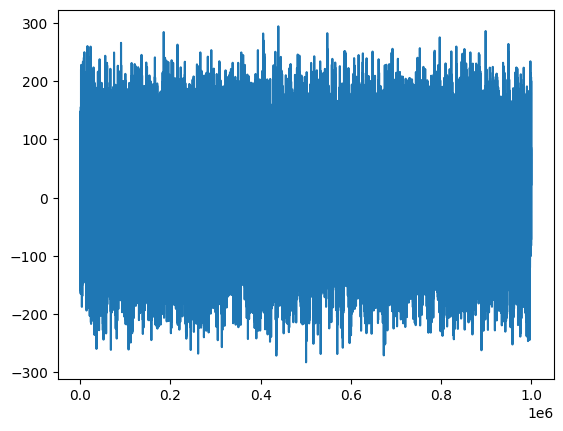

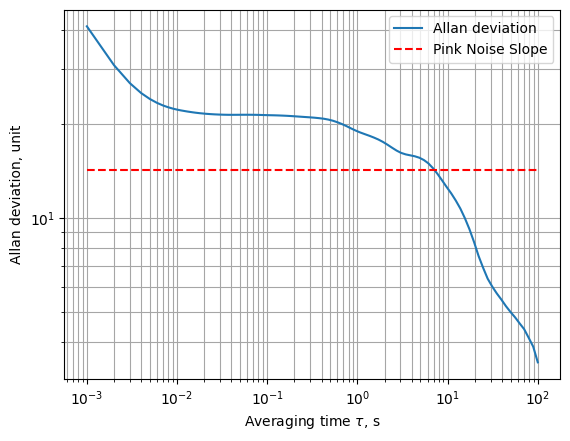

In [16]:
B = 12
sig = B / np.sqrt(2. * np.pi) * PinkNoise(
    f_sample= 1000,
    f_min= 0.1,
    f_max= 100,
    init_filter= True,
    seed= None,
).get_series(1000*1000)

plt.plot(sig)


from firefly.math.allan import params_from_avar, plot_allan_deviation, allan_variance, identify_pink_noise_coefficient

(tau, adev) = allan_variance(sig, 1/1000)

ax = plot_allan_deviation(tau, np.sqrt(adev))

B = identify_pink_noise_coefficient(
    tau= tau,
    adev= np.sqrt(adev),
    ax= ax,
)

print(f"B = {B}")

a = params_from_avar(
    tau= tau,
    avar= adev,
    effects = ['flicker']
)

print(a)
